# Modeling Holidays and Special Events
We will use the time series of the log daily page views for the Wikipedia page for Peyton Manning as an example.
First, we load the data:

In [1]:
import pandas as pd
from neuralprophet import NeuralProphet

In [2]:
df = pd.read_csv('../example_data/wp_log_peyton_manning.csv')

In [3]:
m = NeuralProphet()
metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, future_periods=365, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[40/40]: 100%|██████████| 40/40 [00:02<00:00, 14.91it/s, SmoothL1Loss=0.00584, MAE=0.374, RegLoss=0]


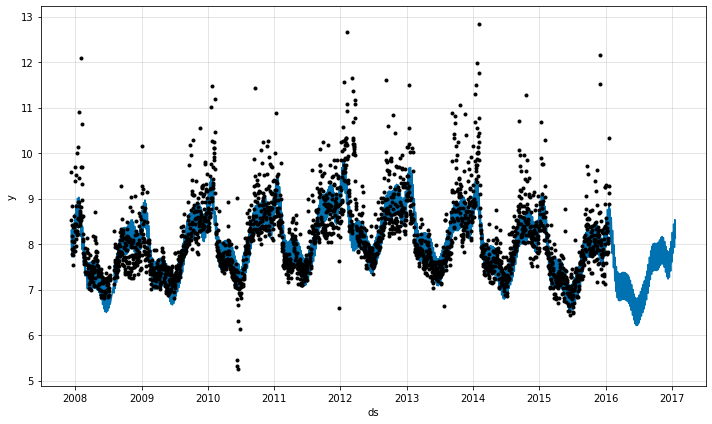

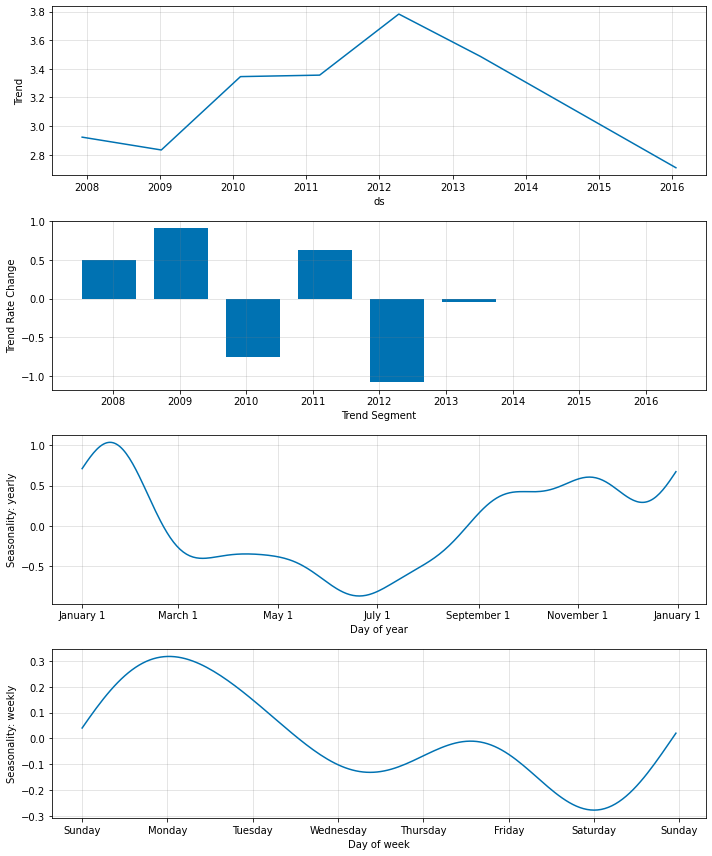

In [4]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()